# NHIS data - ASD prediction

## Goal
The goal is to predict what percentage of adult sample have ASD (Autism Spectrum Disorder) using the child sample data (questionaires).

Note that the adult dataset does NOT have question that specifically asks for having ASD or not (while child data does), and therefore this is a prediction with large assumption that the child (questionaire) data can be used to extrapolate the questions and behaviors of the adults. 

## (Planned) Outline
* Imports
   * Import data
   * Import libraries
   * Scripts
      * Store model testing results
      * Store models 
      
* Decide on initial features
   * Hand pick features (offline) initially 
   * Adult & child feature comparison (google sheets)
   * Filter features based on collinearity
* Transform & derive features
* Model training & eval against child data
* Model eval against adult data


* Past model testing iterations

# Prep

In [513]:
REBUILD_MODELS = True #flag to decide if the script should rebuild all ML models, or load if it exists
TARGET = 'ASDEV' # Use ASDEV for autism, ADHDEV for ADHD

In [514]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import stats
import statsmodels.api as sm
import seaborn as sns


import os
        
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
import pickle


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from phik import phik_matrix
from scipy.stats import chi2_contingency


pd.set_option('display.max_rows', 500)  # Set the option to display all rows
pd.set_option('display.max_columns', 100)  # Set the option to display all rows

#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')

In [515]:
#import data and reserve the originals as read only

dfc22_orig = pd.read_csv('source/child22.csv')
dfa22_orig = pd.read_csv('source/adult22.csv')
dfc21_orig = pd.read_csv('source/child21.csv')
dfa21_orig = pd.read_csv('source/adult21.csv')
dfc20_orig = pd.read_csv('source/child20.csv')
dfa20_orig = pd.read_csv('source/adult20.csv')
dfc19_orig = pd.read_csv('source/child19.csv')
dfa19_orig = pd.read_csv('source/adult19.csv')



#Copying to working dataframe, also removing columns not planned to be used
#Fields to be extracted are decided on a separate spreadsheet
dfc22 = dfc22_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'HISP_C', 'HISPALLP_C', 'RACEALLP_C', 'HISDETP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'LSATIS11_C', 'ASEV_C', 'ASTILL_C', 'ASAT12M_C', 'ASER12M_C', 'PREDIB_C', 'DIBEV_C', 'ADHDEV_C', 'ADHDNW_C', 'IDEV1_C', 'IDNW1_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'BMICAT_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARAID_C', 'HEARINGDF_C', 'PICKUPDF_C', 'SELFCAREDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'THERA12M_C', 'HOMEHC12M_C', 'MHRX_C', 'MHTHRPY_C', 'MHTHDLY_C', 'MHTHND_C', 'SDQ1_C', 'SDQ2_C', 'SDQ3_C', 'SDQ4_C', 'SDQ5_C', 'SDQ6_C', 'SDQ7_C', 'SDQ8_C', 'SDQ9_C', 'SDQ10_C', 'SDQ11_C', 'SDQ12_C', 'SDQ13_C', 'SDQ14_C', 'SDQ15_C', 'SDQ16_C', 'SDQ17_C', 'SDQ18_C', 'SDQ19_C', 'SDQ20_C', 'SDQ21_C', 'SDQ22_C', 'SDQ23_C', 'SDQ24_C', 'SDQ25_C', 'SDQIMP1_C', 'SDQIMP2_C', 'SDQIMP3_C', 'SDQIMP4_C', 'SDQIMP5_C', 'SDQIMP6_C', 'SDQIMP7_C', 'SDQIMP8_C', 'SDQEMOT_C', 'SDQCOND_C', 'SDQHYPE_C', 'SDQPEER_C', 'SDQPROS_C', 'SDQTOT_C', 'SDQIMPTOT_C', 'VIOLENEV_C', 'JAILEV1_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'PUTDOWN_C', 'BNEEDS_C', 'UNFAIRRE_C', 'UNFAIRSO_C', 'BULLYVIC_C', 'CYBERVIC_C', 'BULLYPERP_C', 'TBILOSTCON_C', 'TBIDAZED_C', 'TBIHEADSYM_C', 'POVRATTC_C', 'RATCAT_C']].copy()
dfc21 = dfc21_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'HISP_C', 'HISPALLP_C', 'RACEALLP_C', 'HISDETP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'LSATIS11_C', 'ASEV_C', 'ASTILL_C', 'ASAT12M_C', 'ASER12M_C', 'PREDIB_C', 'DIBEV_C', 'ADHDEV_C', 'ADHDNW_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARAID_C', 'HEARINGDF_C', 'PICKUPDF_C', 'SELFCAREDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'MHRX_C', 'MHTHRPY_C', 'VIOLENEV_C', 'JAILEV1_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'PUTDOWN_C', 'BNEEDS_C', 'UNFAIRRE_C', 'UNFAIRSO_C', 'BULLYVIC_C', 'CYBERVIC_C', 'BULLYPERP_C', 'TBILOSTCON_C', 'TBIDAZED_C', 'TBIHEADSYM_C', 'POVRATTC_C', 'RATCAT_C']].copy()
dfc20 = dfc20_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'HISP_C', 'HISPALLP_C', 'RACEALLP_C', 'HISDETP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'ASEV_C', 'ASTILL_C', 'ASAT12M_C', 'ASER12M_C', 'PREDIB_C', 'DIBEV_C', 'ADHDEV_C', 'ADHDNW_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'BMICAT_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARAID_C', 'HEARINGDF_C', 'PICKUPDF_C', 'SELFCAREDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'THERA12M_C', 'HOMEHC12M_C', 'MHRX_C', 'MHTHRPY_C', 'MHTHDLY_C', 'MHTHND_C', 'TBILOSTCON_C', 'TBIDAZED_C', 'TBIHEADSYM_C', 'POVRATTC_C', 'RATCAT_C']].copy()
dfc19 = dfc19_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_C', 'REGION', 'INTV_QRT', 'HHSTAT_C', 'RELTIVP_C', 'SEX_C', 'AGEP_C', 'HISP_C', 'HISPALLP_C', 'RACEALLP_C', 'HISDETP_C', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_C', 'PCNTKIDS_C', 'OVER65FLG_C', 'MLTFAMFLG_C', 'PHSTAT_C', 'ASEV_C', 'ASTILL_C', 'ASAT12M_C', 'ASER12M_C', 'PREDIB_C', 'DIBEV_C', 'ADHDEV_C', 'ADHDNW_C', 'ASDEV_C', 'ASDNW_C', 'DDEV_C', 'DDNW_C', 'LDEV_C', 'LDNW_C', 'WEARGLSS_C', 'VISIONDF_C', 'HEARAID_C', 'HEARINGDF_C', 'PICKUPDF_C', 'SELFCAREDF_C', 'UNDRSTYOU_C', 'UNDRSTCHD_C', 'UNDRSTIHH_C', 'UNDRSTOHH_C', 'LEARNDF_C', 'REMEMBERDF_C', 'ANXFREQ_C', 'DEPFREQ_C', 'BEHDFPLYG_C', 'BEHKBHYG_C', 'BEHDFCNTR_C', 'BEHDFFCS_C', 'BEHDFCHG_C', 'BEHDFMKFR_C', 'BSCNWPPL_C', 'BSCNWPLCS_C', 'BSCCHG_C', 'BSCHLOPPL_C', 'BSCCRYALT_C', 'BSCCLMDWN_C', 'BSCFUSSY_C', 'BSCSTHE_C', 'BSCSCHD_C', 'BSCPTSLP_C', 'BSCSTYSLP_C', 'SCHSPEDEV_C', 'SCHSPED_C', 'SCHSPEDEM_C', 'THERA12M_C', 'HOMEHC12M_C', 'MHRX_C', 'MHTHRPY_C', 'MHTHDLY_C', 'MHTHND_C', 'SDQ1_C', 'SDQ2_C', 'SDQ3_C', 'SDQ4_C', 'SDQ5_C', 'SDQ6_C', 'SDQ7_C', 'SDQ8_C', 'SDQ9_C', 'SDQ10_C', 'SDQ11_C', 'SDQ12_C', 'SDQ13_C', 'SDQ14_C', 'SDQ15_C', 'SDQ16_C', 'SDQ17_C', 'SDQ18_C', 'SDQ19_C', 'SDQ20_C', 'SDQ21_C', 'SDQ22_C', 'SDQ23_C', 'SDQ24_C', 'SDQ25_C', 'SDQIMP1_C', 'SDQIMP2_C', 'SDQIMP3_C', 'SDQIMP4_C', 'SDQIMP5_C', 'SDQIMP6_C', 'SDQIMP7_C', 'SDQIMP8_C', 'SDQEMOT_C', 'SDQCOND_C', 'SDQHYPE_C', 'SDQPEER_C', 'SDQPROS_C', 'SDQTOT_C', 'SDQIMPTOT_C', 'VIOLENEV_C', 'MENTDEPEV_C', 'ALCDRUGEV_C', 'POVRATTC_C', 'RATCAT_C']].copy()



dfa22 = dfa22_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'EDUCP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'LSATIS4_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'CVDDIAG_A', 'POSTEST_A', 'CVDSEV_A', 'LONGCVD_A', 'SYMPNOW_A', 'DENPREV_A', 'DENDL12M_A', 'DENNG12M_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'PHQ81_A', 'PHQ82_A', 'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A', 'PHQCAT_A', 'GAD71_A', 'GAD72_A', 'GAD73_A', 'GAD74_A', 'GAD75_A', 'GAD76_A', 'GAD77_A', 'GADCAT_A', 'SMKTLK1_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()
dfa21 = dfa21_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'EDUCP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'CVDDIAG_A', 'CVDSEV_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()
dfa20 = dfa20_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'INTV_MON', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'CVDDIAG_A', 'CVDSEV_A', 'DENPREV_A', 'DENDL12M_A', 'DENNG12M_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()
dfa19 = dfa19_orig[['RECTYPE', 'SRVY_YR', 'HHX', 'WTFA_A', 'REGION', 'INTV_QRT', 'HHSTAT_A', 'AVAIL_A', 'PROXY_A', 'PROXYREL_A', 'SEX_A', 'AGEP_A', 'AGE65', 'RACEALLP_A', 'PCNTLT18TC', 'PCNT18UPTC', 'PCNTADLT_A', 'PCNTKIDS_A', 'OVER65FLG_A', 'PHSTAT_A', 'HYPEV_A', 'HYPDIF_A', 'HYP12M_A', 'ANXEV_A', 'DEPEV_A', 'COMDIFF_A', 'COGMEMDFF_A', 'COGTYPEDFF_A', 'COGFRQDFF_A', 'COGAMTDFF_A', 'OGHDHP_A', 'PLEXCHOG_A', 'OGFLG_A', 'MILITARY_A', 'MILSPC1R_A', 'MILSPC2_A', 'MILSPC3_A', 'IHS_A', 'HILAST_A', 'HILASTMY_A', 'HISTOPJOB_A', 'HISTOPMISS_A', 'HISTOPAGE_A', 'HISTOPCOST_A', 'HISTOPELIG_A', 'RSNHICOST_A', 'RSNHIWANT_A', 'RSNHIELIG_A', 'RSNHICONF_A', 'RSNHIMEET_A', 'RSNHIWAIT_A', 'RSNHIOTH_A', 'RSNHIJOB_A', 'RSNHIMISS_A', 'HINOTYR_A', 'HINOTMYR_A', 'MILSPC1_A', 'HICOV_A', 'HIKIND01_A', 'HIKIND02_A', 'HIKIND03_A', 'HIKIND04_A', 'HIKIND05_A', 'HIKIND06_A', 'HIKIND07_A', 'HIKIND08_A', 'HIKIND09_A', 'HIKIND10_A', 'MCAREPRB_A', 'MCAIDPRB_A', 'PAYBLL12M_A', 'PAYNOBLLNW_A', 'PAYWORRY_A', 'DENPREV_A', 'DENDL12M_A', 'DENNG12M_A', 'LASTDR_A', 'WELLNESS_A', 'ANXFREQ_A', 'ANXMED_A', 'ANXLEVEL_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'MHRX_A', 'MHTHRPY_A', 'MHTPYNOW_A', 'PHQ81_A', 'PHQ82_A', 'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A', 'PHQCAT_A', 'GAD71_A', 'GAD72_A', 'GAD73_A', 'GAD74_A', 'GAD75_A', 'GAD76_A', 'GAD77_A', 'GADCAT_A', 'ECIGEV_A', 'CIGARCUR_A']].copy()

#dfcall = pd.concat([dfc22,dfc21,dfc20,dfc19],axis=0)
dfcall = pd.concat([dfc22,dfc21,dfc20,dfc19],axis=0)

dfaall = pd.concat([dfa22,dfa21,dfa20,dfa19],axis=0)


In [516]:
# Helper functions

results = pd.DataFrame(columns = ['model','set','precision','recall','F1','accuracy'])


def add_train_results(results, model_name:str, model_object, metric:str):
    '''
    Input:
    results (dataframe): Dataframe to append the model results
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Adds F1, recall, precision, and accuracy scores for model with the best mean 
    'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    results.loc[len(results)] = [model_name,'CV',precision,recall,f1,accuracy]
    return results


def add_test_results(results, model_name:str, y_test, y_pred):
    '''
    Input:
    results (dataframe): Dataframe to append the model results
    model_name (string): what you want the model to be called in the output table
    y_test: test set 
    y_pred: predictions from the model
    '''
    f1 = f1_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    accuracy =accuracy_score(y_test,y_pred)
    
    results.loc[len(results)] = [model_name,'TEST',precision,recall,f1,accuracy]
    return results
    

# Feature selection

## Initial feature Selection

**Features (the questions in the survey) has been handpicked based on the follwoing criteria** 
* Similar field exist between adult survey and child survey
* The question was consistently being asked for the last 4 years (2019~2022)
* Questions that will have *obvious* difference between adult and child (e.g. how many people living in the household)


**Note that ethical correctness is not considered here. For example using race may require some more consideration IF this was real-world use case, depending on what the application is**

In [517]:
dfc_training = dfcall[["ASDEV_C","ADHDEV_C","REGION","SEX_C","AGEP_C","HISP_C","HISPALLP_C","RACEALLP_C","HISDETP_C","PHSTAT_C","ASEV_C","PREDIB_C","DIBEV_C","ANXFREQ_C","DEPFREQ_C","WEARGLSS_C","HEARAID_C","BEHDFFCS_C","REMEMBERDF_C","POVRATTC_C","RATCAT_C"]]
dfc_training.head(10)

,ASDEV_C,ADHDEV_C,REGION,SEX_C,AGEP_C,HISP_C,HISPALLP_C,RACEALLP_C,HISDETP_C,PHSTAT_C,ASEV_C,PREDIB_C,DIBEV_C,ANXFREQ_C,DEPFREQ_C,WEARGLSS_C,HEARAID_C,BEHDFFCS_C,REMEMBERDF_C,POVRATTC_C,RATCAT_C
0,2.0,2.0,3,1,8,2,2,1,3,1,2,2,2,3.0,5.0,2.0,2.0,1.0,1.0,11.00,14
1,2.0,2.0,3,2,8,2,2,1,3,1,2,2,2,5.0,5.0,2.0,2.0,1.0,1.0,1.07,4
2,2.0,2.0,3,1,2,2,3,2,3,3,2,2,2,NaN,NaN,2.0,2.0,NaN,NaN,3.66,11
3,2.0,1.0,3,2,14,2,3,2,3,4,1,1,2,2.0,3.0,1.0,2.0,1.0,1.0,4.55,13
4,2.0,2.0,3,1,7,2,3,2,3,3,2,2,2,5.0,5.0,2.0,2.0,4.0,1.0,0.56,2
5,2.0,1.0,4,1,8,2,2,1,3,1,2,2,2,4.0,5.0,2.0,2.0,1.0,1.0,6.18,14
6,2.0,2.0,4,1,11,2,2,1,3,1,2,2,2,3.0,4.0,2.0,2.0,1.0,1.0,5.27,14
7,NaN,NaN,4,2,1,2,3,2,3,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,3.62,11
8,NaN,NaN,4,2,1,2,4,3,3,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,3.63,11
9,1.0,2.0,4,1,8,2,2,1,3,3,2,2,2,1.0,4.0,2.0,2.0,1.0,1.0,7.92,14


## Feature transformation & Derived features

In [518]:
# Identifying columns to transform based on the max value for the column
column_maxes = (dfc_training.describe().transpose().reset_index()).loc[:,['index','max']].sort_values(by='max',ascending=False)

# If max value = 88 or 99, that column is a numeric field (e.g. SQD impact score), but 88 being "Not ascertained" or 99 not sure. Therefore, changing it to null
max_eighty_eights = column_maxes.loc[column_maxes['max'] ==88,'index'].tolist()
for column in max_eighty_eights:
    dfc_training.loc[dfc_training[column] == 88,column] = None
    dfc_training.loc[dfc_training[column] == 99,column] = None

# Update max values
column_maxes = (dfc_training.describe().transpose().reset_index()).loc[:,['index','max']].sort_values(by='max',ascending=False)

# If max value is 7, 8 or 9, then it is an ordinal value (1~5 OR 1~3), with 7 = refused, 8 = not ascertained, 9 = Don't know. We are going to change these to null
max_eight_or_nines = column_maxes.loc[column_maxes['max'].isin([7.0,8.0,9.0]),'index'].tolist()
for column in max_eight_or_nines:
    print(column)
    dfc_training.loc[dfc_training[column].isin([7.0,8.0,9.0]),column] = None

# Update max values
column_maxes = (dfc_training.describe().transpose().reset_index()).loc[:,['index','max']].sort_values(by='max',ascending=False)

# If max is 2.0, then it's binary. Changing it to 0 VS 1 (instead of 1 VS 2)
binaries = column_maxes.loc[column_maxes['max'].isin([2.0]),'index'].tolist()
for column in binaries:
    dfc_training.loc[dfc_training[column].isin([2.0]),column] = 0.0


PREDIB_C
REMEMBERDF_C
BEHDFFCS_C
HEARAID_C
DEPFREQ_C
ANXFREQ_C
DIBEV_C
ASDEV_C
ADHDEV_C
PHSTAT_C
HISDETP_C
RACEALLP_C
SEX_C
ASEV_C
WEARGLSS_C
HISPALLP_C


## Collinearity check

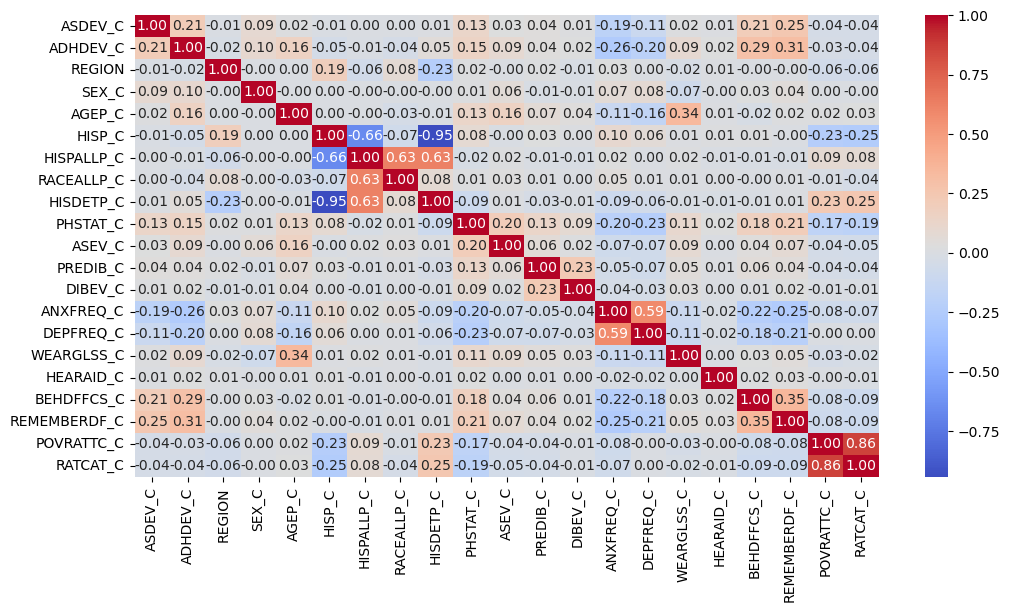

In [519]:

correlation_matrix = dfc_training.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

**Features to remove**
* HISP_C - Will use HISDETP_C instaed
* POVRATTC_C - Will use  RATCAT_C

*ANXFREQ_C* and *DEPFREQ_C* has pretty high correlation, but based on looking at similarity, it was determined it's differentiated enough to include both

In [520]:
dfc_training = dfc_training.drop(['HISP_C','POVRATTC_C'],axis=1)
dfc_training = dfc_training.dropna(subset=[TARGET+'_C'],axis=0)

In [521]:
#Freeze the original training data for later reuse
dfc_training_orig = dfc_training.copy()

# Model training

In [522]:
random = 0
results = pd.DataFrame(columns = ['model','set','precision','recall','F1','accuracy'])

## Round 1 - Gradient boost
**Why Gradient boost?** 
* Some feature values have a lot of null values
* The feature set is a mix of nominal and categorical variables

In [523]:
dfc_training = dfc_training_orig.copy()

model_name = 'histgbdt_all_feat'
results = results[results['model'] != model_name]

classifier = HistGradientBoostingClassifier(random_state=random)

cv_params = {'max_depth': [5,10,20],
             'min_samples_leaf': [1,2,4],
             }

scoring = ['accuracy', 'recall', 'f1','precision']
# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [524]:
y = dfc_training[[TARGET+'_C']]
X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)


In [525]:
%%time
if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
    grid.fit(X_train, y_train.values.ravel())
else: 
    with open('models/'+model_name+'_grid.pkl', 'rb') as f:
        grid = pickle.load(f)

CPU times: total: 2min 56s
Wall time: 30.3 s


In [526]:
results = add_train_results(results, model_name, grid, 'recall')
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834


In [527]:
best_params = grid.best_params_

# Train a new model with the best parameters
best_clf = HistGradientBoostingClassifier(**best_params)
best_clf.fit(X_train, y_train.values.ravel())
y_pred = best_clf.predict(X_test)

results = add_test_results(results, model_name, y_test,y_pred)
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971


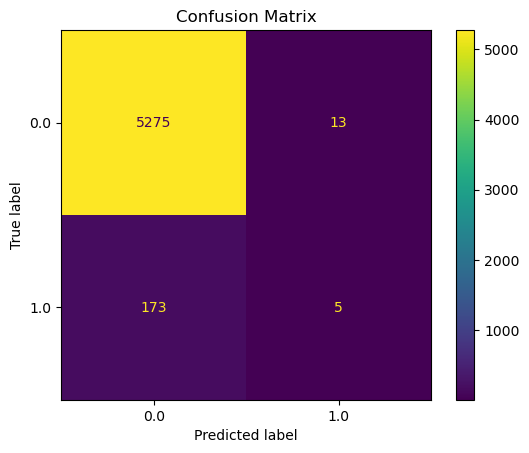

In [528]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Observations
* Recall is way too low, even if maximizing for recall 
* Next round ideas
   * Be more selective in feature set 
   * Impute null values and use other classifiers

In [529]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


## Round 2 - Gradient boost with less features
* Reducing features that may "seem" noisy. At this point it is just based on domain knowledge

In [530]:
dfc_training = dfc_training_orig.copy()

model_name = 'histgbdt_handpick_feat'
results = results[results['model'] != model_name]

classifier = HistGradientBoostingClassifier(random_state=random)

cv_params = {'max_depth': [5,10,20],
             'min_samples_leaf': [1,2,4],
             }
scoring = ['accuracy', 'recall', 'f1','precision']
# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [531]:
y = dfc_training[[TARGET+'_C']]
X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)


In [532]:
%%time
if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
    print("eh?")
    grid.fit(X_train, y_train.values.ravel())
else: 
    with open('models/'+model_name+'_grid.pkl', 'rb') as f:
        grid = pickle.load(f)

eh?
CPU times: total: 3min 34s
Wall time: 40.8 s


In [533]:
results = add_train_results(results, model_name, grid, 'recall')
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834


In [534]:
best_params = grid.best_params_

# Train a new model with the best parameters
best_clf = HistGradientBoostingClassifier(**best_params)
best_clf.fit(X_train, y_train.values.ravel())
y_pred = best_clf.predict(X_test)

results = add_test_results(results, model_name, y_test,y_pred)
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069


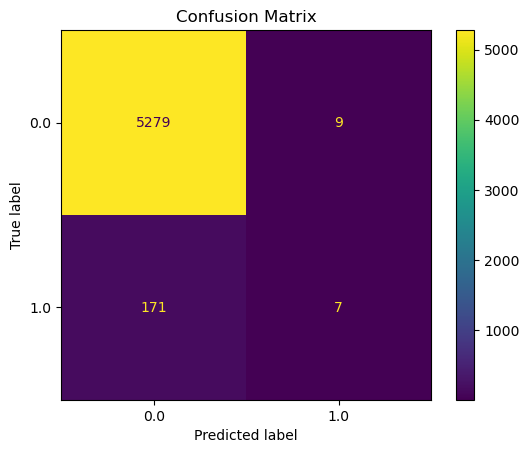

In [535]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Observations
* Not really that different from round 2
* Next round ideas
   * Impute null values
   * Use random forest and other classifiers

In [536]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


## Round 3 - Gradient boost impute NANs
* The NANs have been ignored and relied on learning's default behaviour. Changing this around by imputing values
* Imputation strategy has been added [here](https://docs.google.com/spreadsheets/d/1N35Jpr0b64IG-9RSO2FGK7vQmldq5gCDOKsvdbnBezo/edit?usp=sharing)


In [537]:
dfc_training = dfc_training_orig.copy()

model_name = 'histgbdt_imputed'
results = results[results['model'] != model_name]

classifier = HistGradientBoostingClassifier(random_state=random)

cv_params = {'max_depth': [5,10,20],
             'min_samples_leaf': [1,2,4],
             }
# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [538]:
y = dfc_training[[TARGET+'_C']]
X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)


X_train['SEX_C'] = X_train['SEX_C'].fillna(0)
X_train['HISPALLP_C'] = X_train['HISPALLP_C'].fillna(2)
X_train['RACEALLP_C'] = X_train['RACEALLP_C'].fillna(1)
X_train['HISDETP_C'] = X_train['HISDETP_C'].fillna(3)
X_train['PHSTAT_C'] = X_train['PHSTAT_C'].fillna(1)
X_train['ASEV_C'] = X_train['ASEV_C'].fillna(0)
X_train['PREDIB_C'] = X_train['PREDIB_C'].fillna(0)
X_train['DIBEV_C'] = X_train['DIBEV_C'].fillna(0)
X_train['WEARGLSS_C'] = X_train['WEARGLSS_C'].fillna(0)
X_train['HEARAID_C'] = X_train['HEARAID_C'].fillna(0)
X_train['BEHDFFCS_C'] = X_train['BEHDFFCS_C'].fillna(1)
X_train['REMEMBERDF_C'] = X_train['REMEMBERDF_C'].fillna(1)
X_train['ANXFREQ_C'] = X_train['ANXFREQ_C'].fillna(5)
X_train['DEPFREQ_C'] = X_train['DEPFREQ_C'].fillna(5)
X_test['SEX_C'] = X_test['SEX_C'].fillna(0)
X_test['HISPALLP_C'] = X_test['HISPALLP_C'].fillna(2)
X_test['RACEALLP_C'] = X_test['RACEALLP_C'].fillna(1)
X_test['HISDETP_C'] = X_test['HISDETP_C'].fillna(3)
X_test['PHSTAT_C'] = X_test['PHSTAT_C'].fillna(1)
X_test['ASEV_C'] = X_test['ASEV_C'].fillna(0)
X_test['PREDIB_C'] = X_test['PREDIB_C'].fillna(0)
X_test['DIBEV_C'] = X_test['DIBEV_C'].fillna(0)
X_test['WEARGLSS_C'] = X_test['WEARGLSS_C'].fillna(0)
X_test['HEARAID_C'] = X_test['HEARAID_C'].fillna(0)
X_test['BEHDFFCS_C'] = X_test['BEHDFFCS_C'].fillna(1)
X_test['REMEMBERDF_C'] = X_test['REMEMBERDF_C'].fillna(1)
X_test['ANXFREQ_C'] = X_test['ANXFREQ_C'].fillna(5)
X_test['DEPFREQ_C'] = X_test['DEPFREQ_C'].fillna(5)

In [539]:
%%time
if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
    grid.fit(X_train, y_train.values.ravel())
else: 
    with open('models/'+model_name+'_grid.pkl', 'rb') as f:
        grid = pickle.load(f)

CPU times: total: 2min 57s
Wall time: 31.1 s


In [540]:
results = add_train_results(results, model_name, grid, 'recall')
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952


In [541]:
best_params = grid.best_params_

# Train a new model with the best parameters
best_clf = HistGradientBoostingClassifier(**best_params)
best_clf.fit(X_train, y_train.values.ravel())
y_pred = best_clf.predict(X_test)

results = add_test_results(results, model_name, y_test,y_pred)
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789


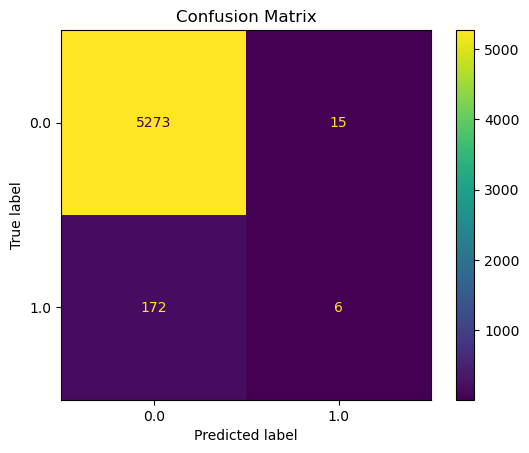

In [542]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Observations
* Not a large difference from round 1

In [543]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


## Round 4 - age filtering 
* Autism for very young age can be noisy. We try different filtering based on age
* We continue using the same imputation mechanism

In [544]:
dfc_training = dfc_training_orig.copy()


model_name = 'histgbdt_age'
results = results[results['model'] != model_name]

classifier = HistGradientBoostingClassifier(random_state=random)

cv_params = {'max_depth': [5,10,20],
             'min_samples_leaf': [1,2,4],
             }
# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [545]:
dfc_training['SEX_C'] = dfc_training['SEX_C'].fillna(0)
dfc_training['HISPALLP_C'] = dfc_training['HISPALLP_C'].fillna(2)
dfc_training['RACEALLP_C'] = dfc_training['RACEALLP_C'].fillna(1)
dfc_training['HISDETP_C'] = dfc_training['HISDETP_C'].fillna(3)
dfc_training['PHSTAT_C'] = dfc_training['PHSTAT_C'].fillna(1)
dfc_training['ASEV_C'] = dfc_training['ASEV_C'].fillna(0)
dfc_training['PREDIB_C'] = dfc_training['PREDIB_C'].fillna(0)
dfc_training['DIBEV_C'] = dfc_training['DIBEV_C'].fillna(0)
dfc_training['WEARGLSS_C'] = dfc_training['WEARGLSS_C'].fillna(0)
dfc_training['HEARAID_C'] = dfc_training['HEARAID_C'].fillna(0)
dfc_training['BEHDFFCS_C'] = dfc_training['BEHDFFCS_C'].fillna(1)
dfc_training['REMEMBERDF_C'] = dfc_training['REMEMBERDF_C'].fillna(1)
dfc_training['ANXFREQ_C'] = dfc_training['ANXFREQ_C'].fillna(5)
dfc_training['DEPFREQ_C'] = dfc_training['DEPFREQ_C'].fillna(5)
dfc_training['SEX_C'] = dfc_training['SEX_C'].fillna(0)
dfc_training['HISPALLP_C'] = dfc_training['HISPALLP_C'].fillna(2)
dfc_training['RACEALLP_C'] = dfc_training['RACEALLP_C'].fillna(1)
dfc_training['HISDETP_C'] = dfc_training['HISDETP_C'].fillna(3)
dfc_training['PHSTAT_C'] = dfc_training['PHSTAT_C'].fillna(1)
dfc_training['ASEV_C'] = dfc_training['ASEV_C'].fillna(0)
dfc_training['PREDIB_C'] = dfc_training['PREDIB_C'].fillna(0)
dfc_training['DIBEV_C'] = dfc_training['DIBEV_C'].fillna(0)
dfc_training['WEARGLSS_C'] = dfc_training['WEARGLSS_C'].fillna(0)
dfc_training['HEARAID_C'] = dfc_training['HEARAID_C'].fillna(0)
dfc_training['BEHDFFCS_C'] = dfc_training['BEHDFFCS_C'].fillna(1)
dfc_training['REMEMBERDF_C'] = dfc_training['REMEMBERDF_C'].fillna(1)
dfc_training['ANXFREQ_C'] = dfc_training['ANXFREQ_C'].fillna(5)
dfc_training['DEPFREQ_C'] = dfc_training['DEPFREQ_C'].fillna(5)

In [546]:
for i in range(0,13,2):
    dfc_training = dfc_training[dfc_training['AGEP_C'] >= i]
    model_name = 'histgbdt_age_'+str(i)+'_or_above'
    y = dfc_training[[TARGET+'_C']]
    X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)
    if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
        grid.fit(X_train, y_train.values.ravel())
    else: 
        with open('models/'+model_name+'_grid.pkl', 'rb') as f:
            grid = pickle.load(f)
    results = add_train_results(results, model_name, grid, 'recall')
    best_params = grid.best_params_

    # Train a new model with the best parameters
    best_clf = HistGradientBoostingClassifier(**best_params)
    best_clf.fit(X_train, y_train.values.ravel())
    y_pred = best_clf.predict(X_test)

    results = add_test_results(results, model_name, y_test,y_pred)


In [547]:
results


,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789
6,histgbdt_age_0_or_above,CV,0.254659,0.049157,0.080818,0.963952
7,histgbdt_age_0_or_above,TEST,0.111111,0.016854,0.029268,0.963593
8,histgbdt_age_2_or_above,CV,0.254659,0.049157,0.080818,0.963952
9,histgbdt_age_2_or_above,TEST,0.285714,0.044944,0.077670,0.965240


### Observations
* Looking at results from TEST, it seems age 8 is the sweet spot. 
* HOwever the recall is still less than 0.1. Let's keep this as a reference point and look at other options
* Test random forest next

In [548]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


## Round 5 - Random forest
* Testing with random forest to see if its robustness will make impactful difference

In [549]:
dfc_training = dfc_training_orig.copy()

model_name = 'rf'
results = results[results['model'] != model_name]

classifier = RandomForestClassifier(random_state=random)


#params for CVSearch
cv_params = {'max_depth': [5,10,20],
#             'max_features': ['auto'],
             'min_samples_leaf': [1,2,4],
             'min_samples_split': [2,5,10],
             'n_estimators': [100,200,500]
             }
# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [550]:
y = dfc_training[[TARGET+'_C']]
X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)
                      
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)


X_train['SEX_C'] = X_train['SEX_C'].fillna(0)
X_train['HISPALLP_C'] = X_train['HISPALLP_C'].fillna(2)
X_train['RACEALLP_C'] = X_train['RACEALLP_C'].fillna(1)
X_train['HISDETP_C'] = X_train['HISDETP_C'].fillna(3)
X_train['PHSTAT_C'] = X_train['PHSTAT_C'].fillna(1)
X_train['ASEV_C'] = X_train['ASEV_C'].fillna(0)
X_train['PREDIB_C'] = X_train['PREDIB_C'].fillna(0)
X_train['DIBEV_C'] = X_train['DIBEV_C'].fillna(0)
X_train['WEARGLSS_C'] = X_train['WEARGLSS_C'].fillna(0)
X_train['HEARAID_C'] = X_train['HEARAID_C'].fillna(0)
X_train['BEHDFFCS_C'] = X_train['BEHDFFCS_C'].fillna(1)
X_train['REMEMBERDF_C'] = X_train['REMEMBERDF_C'].fillna(1)
X_train['ANXFREQ_C'] = X_train['ANXFREQ_C'].fillna(5)
X_train['DEPFREQ_C'] = X_train['DEPFREQ_C'].fillna(5)
X_test['SEX_C'] = X_test['SEX_C'].fillna(0)
X_test['HISPALLP_C'] = X_test['HISPALLP_C'].fillna(2)
X_test['RACEALLP_C'] = X_test['RACEALLP_C'].fillna(1)
X_test['HISDETP_C'] = X_test['HISDETP_C'].fillna(3)
X_test['PHSTAT_C'] = X_test['PHSTAT_C'].fillna(1)
X_test['ASEV_C'] = X_test['ASEV_C'].fillna(0)
X_test['PREDIB_C'] = X_test['PREDIB_C'].fillna(0)
X_test['DIBEV_C'] = X_test['DIBEV_C'].fillna(0)
X_test['WEARGLSS_C'] = X_test['WEARGLSS_C'].fillna(0)
X_test['HEARAID_C'] = X_test['HEARAID_C'].fillna(0)
X_test['BEHDFFCS_C'] = X_test['BEHDFFCS_C'].fillna(1)
X_test['REMEMBERDF_C'] = X_test['REMEMBERDF_C'].fillna(1)
X_test['ANXFREQ_C'] = X_test['ANXFREQ_C'].fillna(5)
X_test['DEPFREQ_C'] = X_test['DEPFREQ_C'].fillna(5)

In [551]:
%%time
if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
    grid.fit(X_train, y_train.values.ravel())
else: 
    with open('models/'+model_name+'_grid.pkl', 'rb') as f:
        grid = pickle.load(f)

C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hiron\anaconda3\Lib\site-packages\sklearn\metrics\_clas

CPU times: total: 10min 53s
Wall time: 23min


In [552]:
results = add_train_results(results, model_name, grid, 'recall')
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789
6,histgbdt_age_0_or_above,CV,0.254659,0.049157,0.080818,0.963952
7,histgbdt_age_0_or_above,TEST,0.111111,0.016854,0.029268,0.963593
8,histgbdt_age_2_or_above,CV,0.254659,0.049157,0.080818,0.963952
9,histgbdt_age_2_or_above,TEST,0.285714,0.044944,0.077670,0.965240


In [553]:
best_params = grid.best_params_

# Train a new model with the best parameters
best_clf = RandomForestClassifier(**best_params)
best_clf.fit(X_train, y_train.values.ravel())
y_pred = best_clf.predict(X_test)

results = add_test_results(results, model_name, y_test,y_pred)
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789
6,histgbdt_age_0_or_above,CV,0.254659,0.049157,0.080818,0.963952
7,histgbdt_age_0_or_above,TEST,0.111111,0.016854,0.029268,0.963593
8,histgbdt_age_2_or_above,CV,0.254659,0.049157,0.080818,0.963952
9,histgbdt_age_2_or_above,TEST,0.285714,0.044944,0.077670,0.965240


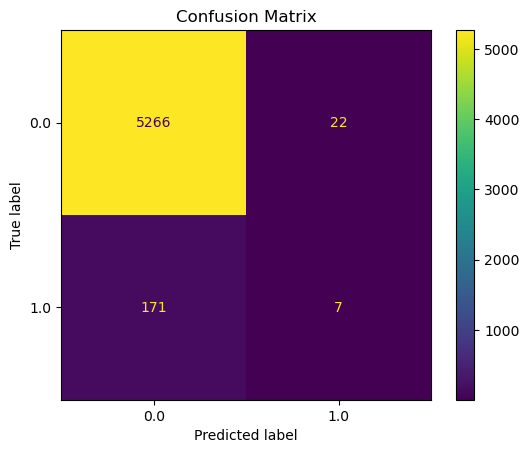

In [554]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Observations
* Not a large difference from round 1

In [555]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


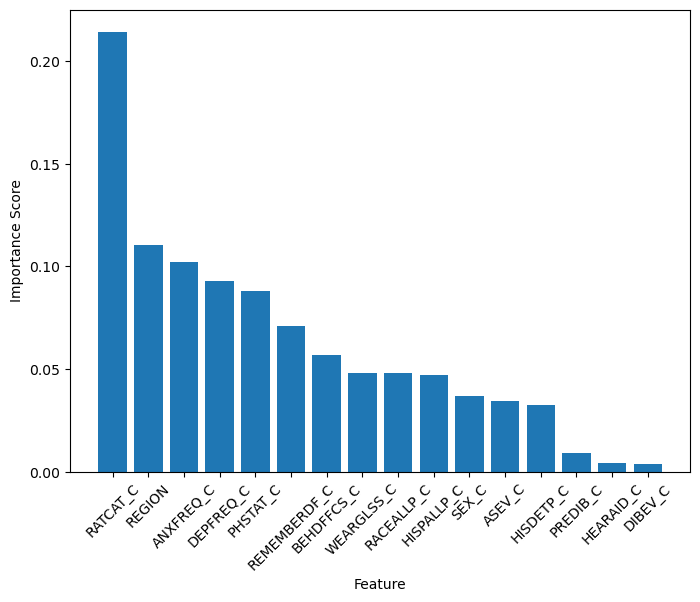

In [556]:
# Get feature importances
feature_importances = best_clf.feature_importances_

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

## Round 6 - XGBoost
* 

In [557]:
dfc_training = dfc_training_orig.copy()

model_name = 'xgboost'
results = results[results['model'] != model_name]

classifier = XGBClassifier(random_state=random)

cv_params = {'max_depth': [3,5,10],
             'objective': ['binary:logistic'],
             'eval_metric': ['error','logloss'],
             'eta' : [0.1,0.2],
             }
# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [558]:
y = dfc_training[[TARGET+'_C']]
X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)


X_train['SEX_C'] = X_train['SEX_C'].fillna(0)
X_train['HISPALLP_C'] = X_train['HISPALLP_C'].fillna(2)
X_train['RACEALLP_C'] = X_train['RACEALLP_C'].fillna(1)
X_train['HISDETP_C'] = X_train['HISDETP_C'].fillna(3)
X_train['PHSTAT_C'] = X_train['PHSTAT_C'].fillna(1)
X_train['ASEV_C'] = X_train['ASEV_C'].fillna(0)
X_train['PREDIB_C'] = X_train['PREDIB_C'].fillna(0)
X_train['DIBEV_C'] = X_train['DIBEV_C'].fillna(0)
X_train['WEARGLSS_C'] = X_train['WEARGLSS_C'].fillna(0)
X_train['HEARAID_C'] = X_train['HEARAID_C'].fillna(0)
X_train['BEHDFFCS_C'] = X_train['BEHDFFCS_C'].fillna(1)
X_train['REMEMBERDF_C'] = X_train['REMEMBERDF_C'].fillna(1)
X_train['ANXFREQ_C'] = X_train['ANXFREQ_C'].fillna(5)
X_train['DEPFREQ_C'] = X_train['DEPFREQ_C'].fillna(5)
X_test['SEX_C'] = X_test['SEX_C'].fillna(0)
X_test['HISPALLP_C'] = X_test['HISPALLP_C'].fillna(2)
X_test['RACEALLP_C'] = X_test['RACEALLP_C'].fillna(1)
X_test['HISDETP_C'] = X_test['HISDETP_C'].fillna(3)
X_test['PHSTAT_C'] = X_test['PHSTAT_C'].fillna(1)
X_test['ASEV_C'] = X_test['ASEV_C'].fillna(0)
X_test['PREDIB_C'] = X_test['PREDIB_C'].fillna(0)
X_test['DIBEV_C'] = X_test['DIBEV_C'].fillna(0)
X_test['WEARGLSS_C'] = X_test['WEARGLSS_C'].fillna(0)
X_test['HEARAID_C'] = X_test['HEARAID_C'].fillna(0)
X_test['BEHDFFCS_C'] = X_test['BEHDFFCS_C'].fillna(1)
X_test['REMEMBERDF_C'] = X_test['REMEMBERDF_C'].fillna(1)
X_test['ANXFREQ_C'] = X_test['ANXFREQ_C'].fillna(5)
X_test['DEPFREQ_C'] = X_test['DEPFREQ_C'].fillna(5)

In [559]:
%%time
if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
    grid.fit(X_train, y_train.values.ravel())
else: 
    with open('models/'+model_name+'_grid.pkl', 'rb') as f:
        grid = pickle.load(f)

CPU times: total: 2min 45s
Wall time: 30.1 s


In [560]:
results = add_train_results(results, model_name, grid, 'recall')
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789
6,histgbdt_age_0_or_above,CV,0.254659,0.049157,0.080818,0.963952
7,histgbdt_age_0_or_above,TEST,0.111111,0.016854,0.029268,0.963593
8,histgbdt_age_2_or_above,CV,0.254659,0.049157,0.080818,0.963952
9,histgbdt_age_2_or_above,TEST,0.285714,0.044944,0.077670,0.965240


In [561]:
best_params = grid.best_params_

# Train a new model with the best parameters
best_clf = XGBClassifier(**best_params)
best_clf.fit(X_train, y_train.values.ravel())
y_pred = best_clf.predict(X_test)

results = add_test_results(results, model_name, y_test,y_pred)
results

,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789
6,histgbdt_age_0_or_above,CV,0.254659,0.049157,0.080818,0.963952
7,histgbdt_age_0_or_above,TEST,0.111111,0.016854,0.029268,0.963593
8,histgbdt_age_2_or_above,CV,0.254659,0.049157,0.080818,0.963952
9,histgbdt_age_2_or_above,TEST,0.285714,0.044944,0.077670,0.965240


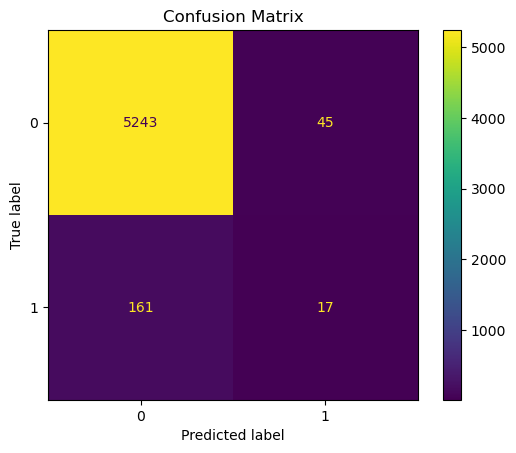

In [562]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Feature importance (gain):
SEX_C: 3.4776759147644043
REMEMBERDF_C: 3.290631055831909
ANXFREQ_C: 1.159911870956421
BEHDFFCS_C: 0.9698920249938965
PHSTAT_C: 0.7162203192710876
RACEALLP_C: 0.6811808347702026
WEARGLSS_C: 0.6720694303512573
RATCAT_C: 0.6454710960388184
ASEV_C: 0.6454325318336487
HISPALLP_C: 0.6412895321846008
DEPFREQ_C: 0.6217801570892334
REGION: 0.6141018271446228
HISDETP_C: 0.5734613537788391
DIBEV_C: 0.5635876655578613
PREDIB_C: 0.5286413431167603
HEARAID_C: 0.20334745943546295


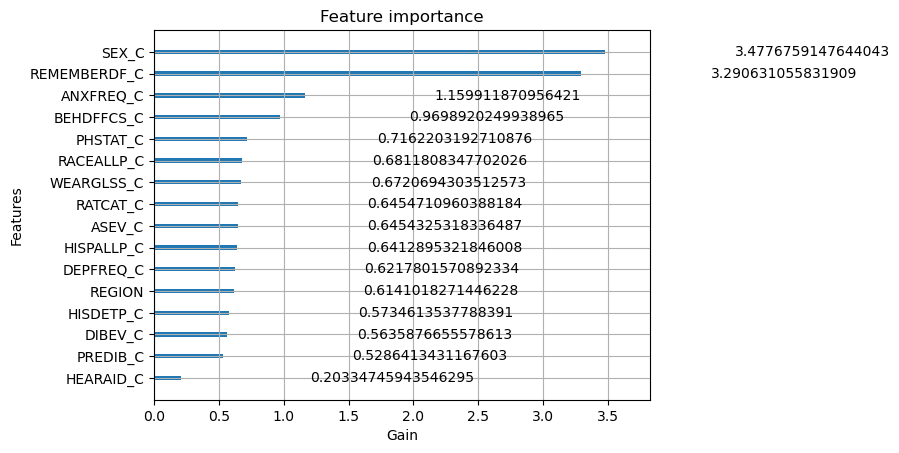

In [563]:
# Get feature importances using plot_importance()
plot_importance(best_clf, importance_type='gain', xlabel='Gain')

# Get feature importances using get_booster().get_score()
importance = best_clf.get_booster().get_score(importance_type='gain')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("Feature importance (gain):")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")

plt.show()

### Observations
* Surprisingly better than the previous rounds

In [564]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


## Round 7 - XGBoost + age filtering
* Autism for very young age can be noisy. We try different filtering based on age
* We continue using the same imputation mechanism

In [565]:
dfc_training = dfc_training_orig.copy()


model_name = 'xgboost_age'
results = results[results['model'] != model_name]

classifier = XGBClassifier(random_state=random)

cv_params = {'max_depth': [3,5,10],
             'objective': ['binary:logistic'],
             'eval_metric': ['error','logloss'],
             'eta' : [0.1,0.2],
             }

# Instantiate the GridSearchCV object
grid = GridSearchCV(classifier, cv_params, scoring=scoring, cv=4, refit='recall')


In [566]:
dfc_training['SEX_C'] = dfc_training['SEX_C'].fillna(0)
dfc_training['HISPALLP_C'] = dfc_training['HISPALLP_C'].fillna(2)
dfc_training['RACEALLP_C'] = dfc_training['RACEALLP_C'].fillna(1)
dfc_training['HISDETP_C'] = dfc_training['HISDETP_C'].fillna(3)
dfc_training['PHSTAT_C'] = dfc_training['PHSTAT_C'].fillna(1)
dfc_training['ASEV_C'] = dfc_training['ASEV_C'].fillna(0)
dfc_training['PREDIB_C'] = dfc_training['PREDIB_C'].fillna(0)
dfc_training['DIBEV_C'] = dfc_training['DIBEV_C'].fillna(0)
dfc_training['WEARGLSS_C'] = dfc_training['WEARGLSS_C'].fillna(0)
dfc_training['HEARAID_C'] = dfc_training['HEARAID_C'].fillna(0)
dfc_training['BEHDFFCS_C'] = dfc_training['BEHDFFCS_C'].fillna(1)
dfc_training['REMEMBERDF_C'] = dfc_training['REMEMBERDF_C'].fillna(1)
dfc_training['ANXFREQ_C'] = dfc_training['ANXFREQ_C'].fillna(5)
dfc_training['DEPFREQ_C'] = dfc_training['DEPFREQ_C'].fillna(5)
dfc_training['SEX_C'] = dfc_training['SEX_C'].fillna(0)
dfc_training['HISPALLP_C'] = dfc_training['HISPALLP_C'].fillna(2)
dfc_training['RACEALLP_C'] = dfc_training['RACEALLP_C'].fillna(1)
dfc_training['HISDETP_C'] = dfc_training['HISDETP_C'].fillna(3)
dfc_training['PHSTAT_C'] = dfc_training['PHSTAT_C'].fillna(1)
dfc_training['ASEV_C'] = dfc_training['ASEV_C'].fillna(0)
dfc_training['PREDIB_C'] = dfc_training['PREDIB_C'].fillna(0)
dfc_training['DIBEV_C'] = dfc_training['DIBEV_C'].fillna(0)
dfc_training['WEARGLSS_C'] = dfc_training['WEARGLSS_C'].fillna(0)
dfc_training['HEARAID_C'] = dfc_training['HEARAID_C'].fillna(0)
dfc_training['BEHDFFCS_C'] = dfc_training['BEHDFFCS_C'].fillna(1)
dfc_training['REMEMBERDF_C'] = dfc_training['REMEMBERDF_C'].fillna(1)
dfc_training['ANXFREQ_C'] = dfc_training['ANXFREQ_C'].fillna(5)
dfc_training['DEPFREQ_C'] = dfc_training['DEPFREQ_C'].fillna(5)

In [567]:
for i in range(0,13,2):
    dfc_training = dfc_training[dfc_training['AGEP_C'] >= i]
    model_name = 'xgboost_age'+str(i)+'_or_above'
    y = dfc_training[[TARGET+'_C']]
    X = dfc_training.drop(['ASDEV_C','ADHDEV_C','AGEP_C'],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random)
    if (REBUILD_MODELS or not (os.path.exists('models/'+model_name+'_grid.pkl'))):
        grid.fit(X_train, y_train.values.ravel())
    else: 
        with open('models/'+model_name+'_grid.pkl', 'rb') as f:
            grid = pickle.load(f)
    results = add_train_results(results, model_name, grid, 'recall')
    best_params = grid.best_params_

    # Train a new model with the best parameters
    best_clf = XGBClassifier(**best_params)
    best_clf.fit(X_train, y_train.values.ravel())
    y_pred = best_clf.predict(X_test)

    results = add_test_results(results, model_name, y_test,y_pred)


In [568]:
results


,model,set,precision,recall,F1,accuracy
0,histgbdt_all_feat,CV,0.433255,0.057584,0.101363,0.966834
1,histgbdt_all_feat,TEST,0.277778,0.028090,0.051020,0.965971
2,histgbdt_handpick_feat,CV,0.433255,0.057584,0.101363,0.966834
3,histgbdt_handpick_feat,TEST,0.437500,0.039326,0.072165,0.967069
4,histgbdt_imputed,CV,0.254659,0.049157,0.080818,0.963952
5,histgbdt_imputed,TEST,0.285714,0.033708,0.060302,0.965789
6,histgbdt_age_0_or_above,CV,0.254659,0.049157,0.080818,0.963952
7,histgbdt_age_0_or_above,TEST,0.111111,0.016854,0.029268,0.963593
8,histgbdt_age_2_or_above,CV,0.254659,0.049157,0.080818,0.963952
9,histgbdt_age_2_or_above,TEST,0.285714,0.044944,0.077670,0.965240


### Observations
* Looking at results from TEST, it seems age 8 is the sweet spot. 
* HOwever the recall is still less than 0.1. Let's keep this as a reference point and look at other options
* Test random forest next

In [569]:
# Assuming 'model' is your trained model object
with open('models/' + model_name + '_grid.pkl', 'wb') as f:
    pickle.dump(grid, f)

with open('models/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(best_clf, f)


# Appendix

<Axes: title={'center': '(Log transformed)'}, xlabel='DEPFREQ_C', ylabel='ANXFREQ_C'>

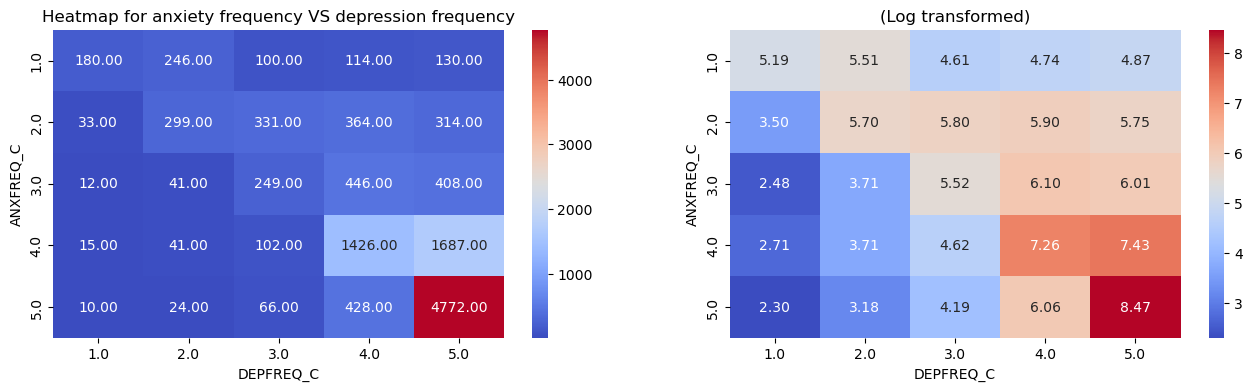

In [570]:
fig, axes = plt.subplots(1, 2, figsize = (16,4))

df = pd.DataFrame(dfc_training[['ANXFREQ_C','DEPFREQ_C']].value_counts().reset_index())
df = df.pivot(index=['ANXFREQ_C'],columns=['DEPFREQ_C'],values='count')

axes[0].set_title("Heatmap for anxiety frequency VS depression frequency")
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f",ax=axes[0])

df2 = df.applymap(np.log)
axes[1].set_title("(Log transformed)")
sns.heatmap(df2, annot=True, cmap='coolwarm', fmt=".2f",ax=axes[1])

